In [1]:
import torch
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from catalyst.dl import SupervisedRunner
from util.data import read_data
from util.model import CovidDataset
from util.features import *

countries, data = read_data(update=False)

data['confirmed'] = np.log10(data['confirmed'] + 1)
data['deaths'] = np.log10(data['deaths'] + 1)
data.head()

/home/tyz910/anaconda3/envs/sberbank-covid19/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


,date,country,confirmed,deaths
0,2020-02-24,AFG,0.30103,0.0
1,2020-02-25,AFG,0.30103,0.0
2,2020-02-26,AFG,0.30103,0.0
3,2020-02-27,AFG,0.30103,0.0
4,2020-02-28,AFG,0.30103,0.0


# Отделяем данные для валидации

In [2]:
VALID_DAYS = 5
VALID_DATE_FROM = data['date'].max() - pd.to_timedelta(VALID_DAYS, unit='d')

train_idx = data[data['date'] <= VALID_DATE_FROM].index
valid_idx = data[data['date'] > VALID_DATE_FROM].index

len(train_idx), len(valid_idx)

(8057, 1257)

# Генерация фичей

In [3]:
def get_y(df):
    return df[['confirmed', 'deaths']]

def get_X(df):
    X = df.copy()
    X = X.join(countries, on='country')[['country', 'confirmed', 'deaths', 'is_region', 'lat', 'long']]
    X = add_prev_values(X, days=5)

    return X.drop(columns=['country', 'confirmed', 'deaths'])

X, y = get_X(data), get_y(data)
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]

X_train.tail()

,is_region,lat,long,confirmed_prev1,deaths_prev1,confirmed_prev2,deaths_prev2,confirmed_prev3,deaths_prev3,confirmed_prev4,deaths_prev4,confirmed_prev5,deaths_prev5
9304,0,-20.0,30.0,1.000000,0.301030,1.000000,0.301030,1.000000,0.301030,1.000000,0.30103,0.954243,0.30103
9305,0,-20.0,30.0,1.041393,0.301030,1.000000,0.301030,1.000000,0.301030,1.000000,0.30103,1.000000,0.30103
9306,0,-20.0,30.0,1.079181,0.477121,1.041393,0.301030,1.000000,0.301030,1.000000,0.30103,1.000000,0.30103
9307,0,-20.0,30.0,1.079181,0.602060,1.079181,0.477121,1.041393,0.301030,1.000000,0.30103,1.000000,0.30103
9308,0,-20.0,30.0,1.079181,0.602060,1.079181,0.602060,1.079181,0.477121,1.041393,0.30103,1.000000,0.30103


# Обучение модели с валидацией

In [4]:
LOG_DIR = "./logs"
NUM_EPOCHS = 1000
BATCH_SIZE = 2048
LEARNING_RATE = 0.001

NUM_FEATURES = len(X_train.columns)
NUM_TARGETS = len(y_train.columns)


class CovidModel(torch.nn.Module):
    def __init__(self):
        super(CovidModel, self).__init__()
        
        self.hidden1 = torch.nn.Sequential(
            torch.nn.Linear(NUM_FEATURES, 64),
            torch.nn.ReLU()
        )

        self.gate = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.Sigmoid()
        )
        
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU()
        )
        
        self.out = torch.nn.Linear(32, NUM_TARGETS)

    def forward(self, X):
        h1 = self.hidden1(X)

        g = self.gate(h1)
        h2 = self.hidden2(h1)

        return self.out(g * h2)


model = CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True),
        "valid": DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

[2020-04-16 20:24:41,009] 
1/1000 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1000 * Epoch 1 (train): _timer/_fps=138188.0933 | _timer/batch_time=0.0149 | _timer/data_time=0.0143 | _timer/model_time=0.0006 | loss=1.5365
1/1000 * Epoch 1 (valid): _timer/_fps=235851.1461 | _timer/batch_time=0.0087 | _timer/data_time=0.0083 | _timer/model_time=0.0004 | loss=1.7088
[2020-04-16 20:24:41,157] 
2/1000 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/1000 * Epoch 2 (train): _timer/_fps=149319.5487 | _timer/batch_time=0.0138 | _timer/data_time=0.0133 | _timer/model_time=0.0004 | loss=1.0854
2/1000 * Epoch 2 (valid): _timer/_fps=24162.1509 | _timer/batch_time=0.0848 | _timer/data_time=0.0844 | _timer/model_time=0.0004 | loss=1.5965
[2020-04-16 20:24:41,228] 
3/1000 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/1000 * Epoch 3 (train): _timer/_fps=146904.0136 | _timer/batch_time=0.0140 | _timer/data_time=0.0136 | _timer/model_time=0.0004 | loss=1.0096
3/1000 * Epoch 3 (valid): _timer/_fps=

[2020-04-16 20:24:42,668] 
23/1000 * Epoch 23 (_base): lr=0.0010 | momentum=0.9000
23/1000 * Epoch 23 (train): _timer/_fps=134280.3293 | _timer/batch_time=0.0156 | _timer/data_time=0.0152 | _timer/model_time=0.0005 | loss=0.0738
23/1000 * Epoch 23 (valid): _timer/_fps=300043.1238 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0763
[2020-04-16 20:24:42,750] 
24/1000 * Epoch 24 (_base): lr=0.0010 | momentum=0.9000
24/1000 * Epoch 24 (train): _timer/_fps=125408.9188 | _timer/batch_time=0.0166 | _timer/data_time=0.0161 | _timer/model_time=0.0005 | loss=0.0704
24/1000 * Epoch 24 (valid): _timer/_fps=291747.9398 | _timer/batch_time=0.0070 | _timer/data_time=0.0067 | _timer/model_time=0.0003 | loss=0.0753
[2020-04-16 20:24:42,818] 
25/1000 * Epoch 25 (_base): lr=0.0010 | momentum=0.9000
25/1000 * Epoch 25 (train): _timer/_fps=157365.2335 | _timer/batch_time=0.0135 | _timer/data_time=0.0130 | _timer/model_time=0.0005 | loss=0.0674
25/1000 * Epoch 25 (v

[2020-04-16 20:24:44,315] 
45/1000 * Epoch 45 (_base): lr=0.0010 | momentum=0.9000
45/1000 * Epoch 45 (train): _timer/_fps=147008.8486 | _timer/batch_time=0.0140 | _timer/data_time=0.0136 | _timer/model_time=0.0004 | loss=0.0304
45/1000 * Epoch 45 (valid): _timer/_fps=250523.0574 | _timer/batch_time=0.0082 | _timer/data_time=0.0077 | _timer/model_time=0.0004 | loss=0.0249
[2020-04-16 20:24:44,396] 
46/1000 * Epoch 46 (_base): lr=0.0010 | momentum=0.9000
46/1000 * Epoch 46 (train): _timer/_fps=131123.8939 | _timer/batch_time=0.0156 | _timer/data_time=0.0151 | _timer/model_time=0.0005 | loss=0.0293
46/1000 * Epoch 46 (valid): _timer/_fps=252548.5724 | _timer/batch_time=0.0081 | _timer/data_time=0.0077 | _timer/model_time=0.0004 | loss=0.0225
[2020-04-16 20:24:44,472] 
47/1000 * Epoch 47 (_base): lr=0.0010 | momentum=0.9000
47/1000 * Epoch 47 (train): _timer/_fps=143886.6043 | _timer/batch_time=0.0143 | _timer/data_time=0.0138 | _timer/model_time=0.0005 | loss=0.0286
47/1000 * Epoch 47 (v

[2020-04-16 20:24:46,126] 
67/1000 * Epoch 67 (_base): lr=0.0010 | momentum=0.9000
67/1000 * Epoch 67 (train): _timer/_fps=165331.0736 | _timer/batch_time=0.0124 | _timer/data_time=0.0120 | _timer/model_time=0.0004 | loss=0.0224
67/1000 * Epoch 67 (valid): _timer/_fps=309034.9184 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0183
[2020-04-16 20:24:46,189] 
68/1000 * Epoch 68 (_base): lr=0.0010 | momentum=0.9000
68/1000 * Epoch 68 (train): _timer/_fps=171673.2863 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0222
68/1000 * Epoch 68 (valid): _timer/_fps=305572.0036 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0156
[2020-04-16 20:24:46,257] 
69/1000 * Epoch 69 (_base): lr=0.0010 | momentum=0.9000
69/1000 * Epoch 69 (train): _timer/_fps=161465.3603 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0219
69/1000 * Epoch 69 (v

[2020-04-16 20:24:47,806] 
89/1000 * Epoch 89 (_base): lr=0.0010 | momentum=0.9000
89/1000 * Epoch 89 (train): _timer/_fps=129709.4132 | _timer/batch_time=0.0297 | _timer/data_time=0.0292 | _timer/model_time=0.0004 | loss=0.0199
89/1000 * Epoch 89 (valid): _timer/_fps=288040.1915 | _timer/batch_time=0.0071 | _timer/data_time=0.0067 | _timer/model_time=0.0004 | loss=0.0123
[2020-04-16 20:24:47,876] 
90/1000 * Epoch 90 (_base): lr=0.0010 | momentum=0.9000
90/1000 * Epoch 90 (train): _timer/_fps=161457.2026 | _timer/batch_time=0.0127 | _timer/data_time=0.0123 | _timer/model_time=0.0004 | loss=0.0199
90/1000 * Epoch 90 (valid): _timer/_fps=303670.7531 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0134
[2020-04-16 20:24:47,942] 
91/1000 * Epoch 91 (_base): lr=0.0010 | momentum=0.9000
91/1000 * Epoch 91 (train): _timer/_fps=161605.9737 | _timer/batch_time=0.0127 | _timer/data_time=0.0123 | _timer/model_time=0.0004 | loss=0.0199
91/1000 * Epoch 91 (v

[2020-04-16 20:24:49,455] 
111/1000 * Epoch 111 (_base): lr=0.0010 | momentum=0.9000
111/1000 * Epoch 111 (train): _timer/_fps=146673.9171 | _timer/batch_time=0.0140 | _timer/data_time=0.0135 | _timer/model_time=0.0005 | loss=0.0183
111/1000 * Epoch 111 (valid): _timer/_fps=284397.2518 | _timer/batch_time=0.0072 | _timer/data_time=0.0068 | _timer/model_time=0.0004 | loss=0.0118
[2020-04-16 20:24:49,623] 
112/1000 * Epoch 112 (_base): lr=0.0010 | momentum=0.9000
112/1000 * Epoch 112 (train): _timer/_fps=130175.4295 | _timer/batch_time=0.0160 | _timer/data_time=0.0155 | _timer/model_time=0.0005 | loss=0.0185
112/1000 * Epoch 112 (valid): _timer/_fps=21743.5872 | _timer/batch_time=0.0942 | _timer/data_time=0.0935 | _timer/model_time=0.0007 | loss=0.0141
[2020-04-16 20:24:49,700] 
113/1000 * Epoch 113 (_base): lr=0.0010 | momentum=0.9000
113/1000 * Epoch 113 (train): _timer/_fps=139574.9772 | _timer/batch_time=0.0147 | _timer/data_time=0.0143 | _timer/model_time=0.0005 | loss=0.0185
113/10

[2020-04-16 20:24:51,253] 
133/1000 * Epoch 133 (_base): lr=0.0010 | momentum=0.9000
133/1000 * Epoch 133 (train): _timer/_fps=148721.5507 | _timer/batch_time=0.0145 | _timer/data_time=0.0141 | _timer/model_time=0.0004 | loss=0.0166
133/1000 * Epoch 133 (valid): _timer/_fps=308957.1123 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0100
[2020-04-16 20:24:51,316] 
134/1000 * Epoch 134 (_base): lr=0.0010 | momentum=0.9000
134/1000 * Epoch 134 (train): _timer/_fps=174558.3749 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0166
134/1000 * Epoch 134 (valid): _timer/_fps=301507.0057 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0123
[2020-04-16 20:24:51,391] 
135/1000 * Epoch 135 (_base): lr=0.0010 | momentum=0.9000
135/1000 * Epoch 135 (train): _timer/_fps=151151.7946 | _timer/batch_time=0.0139 | _timer/data_time=0.0135 | _timer/model_time=0.0004 | loss=0.0167
135/1

[2020-04-16 20:24:53,031] 
155/1000 * Epoch 155 (_base): lr=0.0010 | momentum=0.9000
155/1000 * Epoch 155 (train): _timer/_fps=163181.1750 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0160
155/1000 * Epoch 155 (valid): _timer/_fps=310464.6014 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0114
[2020-04-16 20:24:53,099] 
156/1000 * Epoch 156 (_base): lr=0.0010 | momentum=0.9000
156/1000 * Epoch 156 (train): _timer/_fps=163078.9643 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0154
156/1000 * Epoch 156 (valid): _timer/_fps=311049.1958 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0094
[2020-04-16 20:24:53,169] 
157/1000 * Epoch 157 (_base): lr=0.0010 | momentum=0.9000
157/1000 * Epoch 157 (train): _timer/_fps=157602.6880 | _timer/batch_time=0.0130 | _timer/data_time=0.0126 | _timer/model_time=0.0004 | loss=0.0155
157/1

[2020-04-16 20:24:54,791] 
177/1000 * Epoch 177 (_base): lr=0.0010 | momentum=0.9000
177/1000 * Epoch 177 (train): _timer/_fps=153511.4922 | _timer/batch_time=0.0138 | _timer/data_time=0.0134 | _timer/model_time=0.0004 | loss=0.0151
177/1000 * Epoch 177 (valid): _timer/_fps=307640.3765 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0097
[2020-04-16 20:24:54,863] 
178/1000 * Epoch 178 (_base): lr=0.0010 | momentum=0.9000
178/1000 * Epoch 178 (train): _timer/_fps=165448.4269 | _timer/batch_time=0.0125 | _timer/data_time=0.0121 | _timer/model_time=0.0004 | loss=0.0149
178/1000 * Epoch 178 (valid): _timer/_fps=258803.1271 | _timer/batch_time=0.0079 | _timer/data_time=0.0076 | _timer/model_time=0.0003 | loss=0.0131
[2020-04-16 20:24:54,935] 
179/1000 * Epoch 179 (_base): lr=0.0010 | momentum=0.9000
179/1000 * Epoch 179 (train): _timer/_fps=163496.0256 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0151
179/1

[2020-04-16 20:24:56,521] 
199/1000 * Epoch 199 (_base): lr=0.0010 | momentum=0.9000
199/1000 * Epoch 199 (train): _timer/_fps=174129.7163 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0139
199/1000 * Epoch 199 (valid): _timer/_fps=27434.5019 | _timer/batch_time=0.0747 | _timer/data_time=0.0743 | _timer/model_time=0.0004 | loss=0.0096
[2020-04-16 20:24:56,586] 
200/1000 * Epoch 200 (_base): lr=0.0010 | momentum=0.9000
200/1000 * Epoch 200 (train): _timer/_fps=171712.4739 | _timer/batch_time=0.0119 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0141
200/1000 * Epoch 200 (valid): _timer/_fps=306061.9466 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0084
[2020-04-16 20:24:56,659] 
201/1000 * Epoch 201 (_base): lr=0.0010 | momentum=0.9000
201/1000 * Epoch 201 (train): _timer/_fps=163367.8397 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0143
201/10

[2020-04-16 20:24:58,194] 
221/1000 * Epoch 221 (_base): lr=0.0010 | momentum=0.9000
221/1000 * Epoch 221 (train): _timer/_fps=173742.0263 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0126
221/1000 * Epoch 221 (valid): _timer/_fps=310812.8448 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0090
[2020-04-16 20:24:58,263] 
222/1000 * Epoch 222 (_base): lr=0.0010 | momentum=0.9000
222/1000 * Epoch 222 (train): _timer/_fps=162544.0409 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0128
222/1000 * Epoch 222 (valid): _timer/_fps=303821.1223 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0073
[2020-04-16 20:24:58,406] 
223/1000 * Epoch 223 (_base): lr=0.0010 | momentum=0.9000
223/1000 * Epoch 223 (train): _timer/_fps=163863.2383 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0126
223/1

[2020-04-16 20:24:59,913] 
243/1000 * Epoch 243 (_base): lr=0.0010 | momentum=0.9000
243/1000 * Epoch 243 (train): _timer/_fps=172998.4418 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0124
243/1000 * Epoch 243 (valid): _timer/_fps=306247.4453 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0096
[2020-04-16 20:24:59,978] 
244/1000 * Epoch 244 (_base): lr=0.0010 | momentum=0.9000
244/1000 * Epoch 244 (train): _timer/_fps=172653.4129 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0122
244/1000 * Epoch 244 (valid): _timer/_fps=305051.1237 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0080
[2020-04-16 20:25:00,046] 
245/1000 * Epoch 245 (_base): lr=0.0010 | momentum=0.9000
245/1000 * Epoch 245 (train): _timer/_fps=162635.1125 | _timer/batch_time=0.0128 | _timer/data_time=0.0123 | _timer/model_time=0.0004 | loss=0.0121
245/1

[2020-04-16 20:25:01,671] 
265/1000 * Epoch 265 (_base): lr=0.0010 | momentum=0.9000
265/1000 * Epoch 265 (train): _timer/_fps=163481.4609 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0121
265/1000 * Epoch 265 (valid): _timer/_fps=259899.3856 | _timer/batch_time=0.0079 | _timer/data_time=0.0076 | _timer/model_time=0.0003 | loss=0.0083
[2020-04-16 20:25:01,743] 
266/1000 * Epoch 266 (_base): lr=0.0010 | momentum=0.9000
266/1000 * Epoch 266 (train): _timer/_fps=157585.8387 | _timer/batch_time=0.0134 | _timer/data_time=0.0130 | _timer/model_time=0.0004 | loss=0.0118
266/1000 * Epoch 266 (valid): _timer/_fps=293422.1893 | _timer/batch_time=0.0070 | _timer/data_time=0.0067 | _timer/model_time=0.0003 | loss=0.0067
[2020-04-16 20:25:01,819] 
267/1000 * Epoch 267 (_base): lr=0.0010 | momentum=0.9000
267/1000 * Epoch 267 (train): _timer/_fps=151557.9209 | _timer/batch_time=0.0136 | _timer/data_time=0.0132 | _timer/model_time=0.0005 | loss=0.0114
267/1

[2020-04-16 20:25:03,405] 
287/1000 * Epoch 287 (_base): lr=0.0010 | momentum=0.9000
287/1000 * Epoch 287 (train): _timer/_fps=132633.5911 | _timer/batch_time=0.0286 | _timer/data_time=0.0283 | _timer/model_time=0.0004 | loss=0.0107
287/1000 * Epoch 287 (valid): _timer/_fps=302931.8166 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0073
[2020-04-16 20:25:03,474] 
288/1000 * Epoch 288 (_base): lr=0.0010 | momentum=0.9000
288/1000 * Epoch 288 (train): _timer/_fps=166279.6597 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0108
288/1000 * Epoch 288 (valid): _timer/_fps=303842.6158 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0071
[2020-04-16 20:25:03,541] 
289/1000 * Epoch 289 (_base): lr=0.0010 | momentum=0.9000
289/1000 * Epoch 289 (train): _timer/_fps=169708.5876 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0107
289/1

[2020-04-16 20:25:05,102] 
309/1000 * Epoch 309 (_base): lr=0.0010 | momentum=0.9000
309/1000 * Epoch 309 (train): _timer/_fps=168342.2828 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0105
309/1000 * Epoch 309 (valid): _timer/_fps=306181.9495 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0068
[2020-04-16 20:25:05,173] 
310/1000 * Epoch 310 (_base): lr=0.0010 | momentum=0.9000
310/1000 * Epoch 310 (train): _timer/_fps=161920.6719 | _timer/batch_time=0.0127 | _timer/data_time=0.0123 | _timer/model_time=0.0004 | loss=0.0105
310/1000 * Epoch 310 (valid): _timer/_fps=308857.1333 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0059
[2020-04-16 20:25:05,307] 
311/1000 * Epoch 311 (_base): lr=0.0010 | momentum=0.9000
311/1000 * Epoch 311 (train): _timer/_fps=136973.8566 | _timer/batch_time=0.0286 | _timer/data_time=0.0282 | _timer/model_time=0.0004 | loss=0.0104
311/1

[2020-04-16 20:25:06,884] 
331/1000 * Epoch 331 (_base): lr=0.0010 | momentum=0.9000
331/1000 * Epoch 331 (train): _timer/_fps=156120.2903 | _timer/batch_time=0.0132 | _timer/data_time=0.0128 | _timer/model_time=0.0004 | loss=0.0104
331/1000 * Epoch 331 (valid): _timer/_fps=308912.6692 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0060
[2020-04-16 20:25:06,954] 
332/1000 * Epoch 332 (_base): lr=0.0010 | momentum=0.9000
332/1000 * Epoch 332 (train): _timer/_fps=168131.2692 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0103
332/1000 * Epoch 332 (valid): _timer/_fps=275142.0433 | _timer/batch_time=0.0074 | _timer/data_time=0.0071 | _timer/model_time=0.0004 | loss=0.0071
[2020-04-16 20:25:07,022] 
333/1000 * Epoch 333 (_base): lr=0.0010 | momentum=0.9000
333/1000 * Epoch 333 (train): _timer/_fps=171654.6932 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0109
333/1

[2020-04-16 20:25:08,626] 
353/1000 * Epoch 353 (_base): lr=0.0010 | momentum=0.9000
353/1000 * Epoch 353 (train): _timer/_fps=170620.6956 | _timer/batch_time=0.0121 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0107
353/1000 * Epoch 353 (valid): _timer/_fps=306761.4668 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0071
[2020-04-16 20:25:08,697] 
354/1000 * Epoch 354 (_base): lr=0.0010 | momentum=0.9000
354/1000 * Epoch 354 (train): _timer/_fps=164055.2558 | _timer/batch_time=0.0125 | _timer/data_time=0.0121 | _timer/model_time=0.0004 | loss=0.0102
354/1000 * Epoch 354 (valid): _timer/_fps=305702.5016 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0062
[2020-04-16 20:25:08,782] 
355/1000 * Epoch 355 (_base): lr=0.0010 | momentum=0.9000
355/1000 * Epoch 355 (train): _timer/_fps=134965.9260 | _timer/batch_time=0.0159 | _timer/data_time=0.0154 | _timer/model_time=0.0004 | loss=0.0100
355/1

[2020-04-16 20:25:10,544] 
375/1000 * Epoch 375 (_base): lr=0.0010 | momentum=0.9000
375/1000 * Epoch 375 (train): _timer/_fps=122139.5979 | _timer/batch_time=0.0302 | _timer/data_time=0.0298 | _timer/model_time=0.0004 | loss=0.0098
375/1000 * Epoch 375 (valid): _timer/_fps=295755.9080 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0065
[2020-04-16 20:25:10,617] 
376/1000 * Epoch 376 (_base): lr=0.0010 | momentum=0.9000
376/1000 * Epoch 376 (train): _timer/_fps=162378.3260 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0100
376/1000 * Epoch 376 (valid): _timer/_fps=296317.0372 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0066
[2020-04-16 20:25:10,704] 
377/1000 * Epoch 377 (_base): lr=0.0010 | momentum=0.9000
377/1000 * Epoch 377 (train): _timer/_fps=133498.9090 | _timer/batch_time=0.0163 | _timer/data_time=0.0158 | _timer/model_time=0.0005 | loss=0.0097
377/1

[2020-04-16 20:25:12,268] 
397/1000 * Epoch 397 (_base): lr=0.0010 | momentum=0.9000
397/1000 * Epoch 397 (train): _timer/_fps=171486.3897 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0098
397/1000 * Epoch 397 (valid): _timer/_fps=304133.0758 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0055
[2020-04-16 20:25:12,343] 
398/1000 * Epoch 398 (_base): lr=0.0010 | momentum=0.9000
398/1000 * Epoch 398 (train): _timer/_fps=158327.5745 | _timer/batch_time=0.0131 | _timer/data_time=0.0127 | _timer/model_time=0.0005 | loss=0.0095
398/1000 * Epoch 398 (valid): _timer/_fps=300064.0861 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0056
[2020-04-16 20:25:12,485] 
399/1000 * Epoch 399 (_base): lr=0.0010 | momentum=0.9000
399/1000 * Epoch 399 (train): _timer/_fps=131784.0285 | _timer/batch_time=0.0288 | _timer/data_time=0.0284 | _timer/model_time=0.0004 | loss=0.0096
399/1

[2020-04-16 20:25:14,067] 
419/1000 * Epoch 419 (_base): lr=0.0010 | momentum=0.9000
419/1000 * Epoch 419 (train): _timer/_fps=170829.3336 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0092
419/1000 * Epoch 419 (valid): _timer/_fps=306291.1247 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0052
[2020-04-16 20:25:14,136] 
420/1000 * Epoch 420 (_base): lr=0.0010 | momentum=0.9000
420/1000 * Epoch 420 (train): _timer/_fps=171527.5582 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0092
420/1000 * Epoch 420 (valid): _timer/_fps=305604.6176 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0054
[2020-04-16 20:25:14,206] 
421/1000 * Epoch 421 (_base): lr=0.0010 | momentum=0.9000
421/1000 * Epoch 421 (train): _timer/_fps=170792.7571 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0092
421/1

[2020-04-16 20:25:15,884] 
441/1000 * Epoch 441 (_base): lr=0.0010 | momentum=0.9000
441/1000 * Epoch 441 (train): _timer/_fps=169740.2363 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0093
441/1000 * Epoch 441 (valid): _timer/_fps=304186.9256 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0051
[2020-04-16 20:25:15,956] 
442/1000 * Epoch 442 (_base): lr=0.0010 | momentum=0.9000
442/1000 * Epoch 442 (train): _timer/_fps=171773.9016 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0096
442/1000 * Epoch 442 (valid): _timer/_fps=308369.2774 | _timer/batch_time=0.0066 | _timer/data_time=0.0063 | _timer/model_time=0.0003 | loss=0.0055
[2020-04-16 20:25:16,029] 
443/1000 * Epoch 443 (_base): lr=0.0010 | momentum=0.9000
443/1000 * Epoch 443 (train): _timer/_fps=166735.1594 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0097
443/1

[2020-04-16 20:25:17,718] 
463/1000 * Epoch 463 (_base): lr=0.0010 | momentum=0.9000
463/1000 * Epoch 463 (train): _timer/_fps=164672.3641 | _timer/batch_time=0.0125 | _timer/data_time=0.0121 | _timer/model_time=0.0004 | loss=0.0093
463/1000 * Epoch 463 (valid): _timer/_fps=23828.2318 | _timer/batch_time=0.0859 | _timer/data_time=0.0855 | _timer/model_time=0.0004 | loss=0.0054
[2020-04-16 20:25:17,818] 
464/1000 * Epoch 464 (_base): lr=0.0010 | momentum=0.9000
464/1000 * Epoch 464 (train): _timer/_fps=122209.6336 | _timer/batch_time=0.0176 | _timer/data_time=0.0171 | _timer/model_time=0.0005 | loss=0.0096
464/1000 * Epoch 464 (valid): _timer/_fps=294811.9090 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0004 | loss=0.0066
[2020-04-16 20:25:17,891] 
465/1000 * Epoch 465 (_base): lr=0.0010 | momentum=0.9000
465/1000 * Epoch 465 (train): _timer/_fps=170898.7503 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0096
465/10

[2020-04-16 20:25:19,547] 
485/1000 * Epoch 485 (_base): lr=0.0010 | momentum=0.9000
485/1000 * Epoch 485 (train): _timer/_fps=170537.4564 | _timer/batch_time=0.0120 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0095
485/1000 * Epoch 485 (valid): _timer/_fps=306498.7723 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0050
[2020-04-16 20:25:19,624] 
486/1000 * Epoch 486 (_base): lr=0.0010 | momentum=0.9000
486/1000 * Epoch 486 (train): _timer/_fps=169436.4804 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0096
486/1000 * Epoch 486 (valid): _timer/_fps=299405.1792 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0069
[2020-04-16 20:25:19,769] 
487/1000 * Epoch 487 (_base): lr=0.0010 | momentum=0.9000
487/1000 * Epoch 487 (train): _timer/_fps=172305.7741 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0101
487/1

[2020-04-16 20:25:21,344] 
507/1000 * Epoch 507 (_base): lr=0.0010 | momentum=0.9000
507/1000 * Epoch 507 (train): _timer/_fps=173852.6379 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0092
507/1000 * Epoch 507 (valid): _timer/_fps=297940.9175 | _timer/batch_time=0.0069 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0059
[2020-04-16 20:25:21,414] 
508/1000 * Epoch 508 (_base): lr=0.0010 | momentum=0.9000
508/1000 * Epoch 508 (train): _timer/_fps=171420.1153 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0093
508/1000 * Epoch 508 (valid): _timer/_fps=302728.9724 | _timer/batch_time=0.0068 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0058
[2020-04-16 20:25:21,484] 
509/1000 * Epoch 509 (_base): lr=0.0010 | momentum=0.9000
509/1000 * Epoch 509 (train): _timer/_fps=173249.9773 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0094
509/1

[2020-04-16 20:25:23,203] 
529/1000 * Epoch 529 (_base): lr=0.0010 | momentum=0.9000
529/1000 * Epoch 529 (train): _timer/_fps=174131.8777 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0092
529/1000 * Epoch 529 (valid): _timer/_fps=306739.5583 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0072
[2020-04-16 20:25:23,273] 
530/1000 * Epoch 530 (_base): lr=0.0010 | momentum=0.9000
530/1000 * Epoch 530 (train): _timer/_fps=173990.0651 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0098
530/1000 * Epoch 530 (valid): _timer/_fps=297909.9186 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0058
[2020-04-16 20:25:23,344] 
531/1000 * Epoch 531 (_base): lr=0.0010 | momentum=0.9000
531/1000 * Epoch 531 (train): _timer/_fps=171069.1114 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0095
531/1

[2020-04-16 20:25:25,041] 
551/1000 * Epoch 551 (_base): lr=0.0010 | momentum=0.9000
551/1000 * Epoch 551 (train): _timer/_fps=131640.1316 | _timer/batch_time=0.0287 | _timer/data_time=0.0283 | _timer/model_time=0.0004 | loss=0.0092
551/1000 * Epoch 551 (valid): _timer/_fps=305300.4902 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0051
[2020-04-16 20:25:25,113] 
552/1000 * Epoch 552 (_base): lr=0.0010 | momentum=0.9000
552/1000 * Epoch 552 (train): _timer/_fps=170188.3022 | _timer/batch_time=0.0121 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0093
552/1000 * Epoch 552 (valid): _timer/_fps=303788.8878 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0047
[2020-04-16 20:25:25,184] 
553/1000 * Epoch 553 (_base): lr=0.0010 | momentum=0.9000
553/1000 * Epoch 553 (train): _timer/_fps=171872.8020 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0090
553/1

[2020-04-16 20:25:26,805] 
573/1000 * Epoch 573 (_base): lr=0.0010 | momentum=0.9000
573/1000 * Epoch 573 (train): _timer/_fps=159964.9096 | _timer/batch_time=0.0131 | _timer/data_time=0.0126 | _timer/model_time=0.0005 | loss=0.0092
573/1000 * Epoch 573 (valid): _timer/_fps=303960.8844 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0045
[2020-04-16 20:25:26,877] 
574/1000 * Epoch 574 (_base): lr=0.0010 | momentum=0.9000
574/1000 * Epoch 574 (train): _timer/_fps=171573.9641 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0086
574/1000 * Epoch 574 (valid): _timer/_fps=305942.0377 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0048
[2020-04-16 20:25:27,019] 
575/1000 * Epoch 575 (_base): lr=0.0010 | momentum=0.9000
575/1000 * Epoch 575 (train): _timer/_fps=130268.6455 | _timer/batch_time=0.0290 | _timer/data_time=0.0286 | _timer/model_time=0.0004 | loss=0.0085
575/1

[2020-04-16 20:25:28,689] 
595/1000 * Epoch 595 (_base): lr=0.0010 | momentum=0.9000
595/1000 * Epoch 595 (train): _timer/_fps=169288.8628 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0089
595/1000 * Epoch 595 (valid): _timer/_fps=304219.2447 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0061
[2020-04-16 20:25:28,767] 
596/1000 * Epoch 596 (_base): lr=0.0010 | momentum=0.9000
596/1000 * Epoch 596 (train): _timer/_fps=157683.1057 | _timer/batch_time=0.0134 | _timer/data_time=0.0129 | _timer/model_time=0.0005 | loss=0.0091
596/1000 * Epoch 596 (valid): _timer/_fps=300725.8995 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0053
[2020-04-16 20:25:28,846] 
597/1000 * Epoch 597 (_base): lr=0.0010 | momentum=0.9000
597/1000 * Epoch 597 (train): _timer/_fps=172398.2253 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0090
597/1

[2020-04-16 20:25:30,601] 
617/1000 * Epoch 617 (_base): lr=0.0010 | momentum=0.9000
617/1000 * Epoch 617 (train): _timer/_fps=171461.3298 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0089
617/1000 * Epoch 617 (valid): _timer/_fps=299405.1792 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0046
[2020-04-16 20:25:30,673] 
618/1000 * Epoch 618 (_base): lr=0.0010 | momentum=0.9000
618/1000 * Epoch 618 (train): _timer/_fps=172549.7311 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0086
618/1000 * Epoch 618 (valid): _timer/_fps=299446.9285 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0052
[2020-04-16 20:25:30,746] 
619/1000 * Epoch 619 (_base): lr=0.0010 | momentum=0.9000
619/1000 * Epoch 619 (train): _timer/_fps=170307.1324 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0085
619/1

[2020-04-16 20:25:32,461] 
639/1000 * Epoch 639 (_base): lr=0.0010 | momentum=0.9000
639/1000 * Epoch 639 (train): _timer/_fps=120067.8011 | _timer/batch_time=0.0304 | _timer/data_time=0.0300 | _timer/model_time=0.0005 | loss=0.0084
639/1000 * Epoch 639 (valid): _timer/_fps=294589.4781 | _timer/batch_time=0.0070 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0048
[2020-04-16 20:25:32,539] 
640/1000 * Epoch 640 (_base): lr=0.0010 | momentum=0.9000
640/1000 * Epoch 640 (train): _timer/_fps=167216.2597 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0084
640/1000 * Epoch 640 (valid): _timer/_fps=297363.3327 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0047
[2020-04-16 20:25:32,617] 
641/1000 * Epoch 641 (_base): lr=0.0010 | momentum=0.9000
641/1000 * Epoch 641 (train): _timer/_fps=167105.8257 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0082
641/1

[2020-04-16 20:25:34,268] 
661/1000 * Epoch 661 (_base): lr=0.0010 | momentum=0.9000
661/1000 * Epoch 661 (train): _timer/_fps=171200.3891 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0084
661/1000 * Epoch 661 (valid): _timer/_fps=306040.1380 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0044
[2020-04-16 20:25:34,341] 
662/1000 * Epoch 662 (_base): lr=0.0010 | momentum=0.9000
662/1000 * Epoch 662 (train): _timer/_fps=172592.0678 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0082
662/1000 * Epoch 662 (valid): _timer/_fps=299134.0922 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0043
[2020-04-16 20:25:34,485] 
663/1000 * Epoch 663 (_base): lr=0.0010 | momentum=0.9000
663/1000 * Epoch 663 (train): _timer/_fps=133786.9978 | _timer/batch_time=0.0286 | _timer/data_time=0.0282 | _timer/model_time=0.0004 | loss=0.0082
663/1

[2020-04-16 20:25:36,185] 
683/1000 * Epoch 683 (_base): lr=0.0010 | momentum=0.9000
683/1000 * Epoch 683 (train): _timer/_fps=145334.3730 | _timer/batch_time=0.0141 | _timer/data_time=0.0137 | _timer/model_time=0.0004 | loss=0.0083
683/1000 * Epoch 683 (valid): _timer/_fps=256799.2404 | _timer/batch_time=0.0080 | _timer/data_time=0.0077 | _timer/model_time=0.0003 | loss=0.0045
[2020-04-16 20:25:36,269] 
684/1000 * Epoch 684 (_base): lr=0.0010 | momentum=0.9000
684/1000 * Epoch 684 (train): _timer/_fps=145804.6878 | _timer/batch_time=0.0141 | _timer/data_time=0.0137 | _timer/model_time=0.0004 | loss=0.0083
684/1000 * Epoch 684 (valid): _timer/_fps=301137.0584 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0054
[2020-04-16 20:25:36,357] 
685/1000 * Epoch 685 (_base): lr=0.0010 | momentum=0.9000
685/1000 * Epoch 685 (train): _timer/_fps=145343.7695 | _timer/batch_time=0.0141 | _timer/data_time=0.0137 | _timer/model_time=0.0004 | loss=0.0087
685/1

[2020-04-16 20:25:38,076] 
705/1000 * Epoch 705 (_base): lr=0.0010 | momentum=0.9000
705/1000 * Epoch 705 (train): _timer/_fps=170334.0900 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0081
705/1000 * Epoch 705 (valid): _timer/_fps=299530.4621 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0042
[2020-04-16 20:25:38,154] 
706/1000 * Epoch 706 (_base): lr=0.0010 | momentum=0.9000
706/1000 * Epoch 706 (train): _timer/_fps=170553.1209 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0081
706/1000 * Epoch 706 (valid): _timer/_fps=317217.5705 | _timer/batch_time=0.0065 | _timer/data_time=0.0062 | _timer/model_time=0.0003 | loss=0.0046
[2020-04-16 20:25:38,230] 
707/1000 * Epoch 707 (_base): lr=0.0010 | momentum=0.9000
707/1000 * Epoch 707 (train): _timer/_fps=167612.4760 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0081
707/1

[2020-04-16 20:25:39,978] 
727/1000 * Epoch 727 (_base): lr=0.0010 | momentum=0.9000
727/1000 * Epoch 727 (train): _timer/_fps=171136.2531 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0093
727/1000 * Epoch 727 (valid): _timer/_fps=28004.0510 | _timer/batch_time=0.0731 | _timer/data_time=0.0728 | _timer/model_time=0.0004 | loss=0.0054
[2020-04-16 20:25:40,056] 
728/1000 * Epoch 728 (_base): lr=0.0010 | momentum=0.9000
728/1000 * Epoch 728 (train): _timer/_fps=168413.2096 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0090
728/1000 * Epoch 728 (valid): _timer/_fps=305702.5016 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0051
[2020-04-16 20:25:40,134] 
729/1000 * Epoch 729 (_base): lr=0.0010 | momentum=0.9000
729/1000 * Epoch 729 (train): _timer/_fps=171156.7124 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0090
729/10

[2020-04-16 20:25:41,827] 
749/1000 * Epoch 749 (_base): lr=0.0010 | momentum=0.9000
749/1000 * Epoch 749 (train): _timer/_fps=170699.8053 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0085
749/1000 * Epoch 749 (valid): _timer/_fps=297992.5967 | _timer/batch_time=0.0069 | _timer/data_time=0.0065 | _timer/model_time=0.0004 | loss=0.0053
[2020-04-16 20:25:41,906] 
750/1000 * Epoch 750 (_base): lr=0.0010 | momentum=0.9000
750/1000 * Epoch 750 (train): _timer/_fps=159265.8063 | _timer/batch_time=0.0129 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0088
750/1000 * Epoch 750 (valid): _timer/_fps=283636.6053 | _timer/batch_time=0.0072 | _timer/data_time=0.0068 | _timer/model_time=0.0004 | loss=0.0049
[2020-04-16 20:25:42,069] 
751/1000 * Epoch 751 (_base): lr=0.0010 | momentum=0.9000
751/1000 * Epoch 751 (train): _timer/_fps=140757.4660 | _timer/batch_time=0.0150 | _timer/data_time=0.0145 | _timer/model_time=0.0005 | loss=0.0087
751/1

[2020-04-16 20:25:43,843] 
771/1000 * Epoch 771 (_base): lr=0.0010 | momentum=0.9000
771/1000 * Epoch 771 (train): _timer/_fps=170815.6114 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0081
771/1000 * Epoch 771 (valid): _timer/_fps=298707.6048 | _timer/batch_time=0.0069 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0042
[2020-04-16 20:25:43,918] 
772/1000 * Epoch 772 (_base): lr=0.0010 | momentum=0.9000
772/1000 * Epoch 772 (train): _timer/_fps=170721.2018 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0082
772/1000 * Epoch 772 (valid): _timer/_fps=299071.6034 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0043
[2020-04-16 20:25:44,001] 
773/1000 * Epoch 773 (_base): lr=0.0010 | momentum=0.9000
773/1000 * Epoch 773 (train): _timer/_fps=170200.0393 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0080
773/1

[2020-04-16 20:25:45,803] 
793/1000 * Epoch 793 (_base): lr=0.0010 | momentum=0.9000
793/1000 * Epoch 793 (train): _timer/_fps=169025.4522 | _timer/batch_time=0.0121 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0081
793/1000 * Epoch 793 (valid): _timer/_fps=300547.0275 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0044
[2020-04-16 20:25:45,883] 
794/1000 * Epoch 794 (_base): lr=0.0010 | momentum=0.9000
794/1000 * Epoch 794 (train): _timer/_fps=170166.4827 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0081
794/1000 * Epoch 794 (valid): _timer/_fps=292762.1619 | _timer/batch_time=0.0070 | _timer/data_time=0.0067 | _timer/model_time=0.0003 | loss=0.0045
[2020-04-16 20:25:45,965] 
795/1000 * Epoch 795 (_base): lr=0.0010 | momentum=0.9000
795/1000 * Epoch 795 (train): _timer/_fps=158850.4522 | _timer/batch_time=0.0130 | _timer/data_time=0.0126 | _timer/model_time=0.0004 | loss=0.0081
795/1

[2020-04-16 20:25:47,785] 
815/1000 * Epoch 815 (_base): lr=0.0010 | momentum=0.9000
815/1000 * Epoch 815 (train): _timer/_fps=134907.0379 | _timer/batch_time=0.0323 | _timer/data_time=0.0319 | _timer/model_time=0.0004 | loss=0.0080
815/1000 * Epoch 815 (valid): _timer/_fps=240594.1963 | _timer/batch_time=0.0085 | _timer/data_time=0.0081 | _timer/model_time=0.0004 | loss=0.0050
[2020-04-16 20:25:47,877] 
816/1000 * Epoch 816 (_base): lr=0.0010 | momentum=0.9000
816/1000 * Epoch 816 (train): _timer/_fps=150040.8650 | _timer/batch_time=0.0138 | _timer/data_time=0.0133 | _timer/model_time=0.0004 | loss=0.0082
816/1000 * Epoch 816 (valid): _timer/_fps=249562.3066 | _timer/batch_time=0.0082 | _timer/data_time=0.0079 | _timer/model_time=0.0003 | loss=0.0045
[2020-04-16 20:25:47,958] 
817/1000 * Epoch 817 (_base): lr=0.0010 | momentum=0.9000
817/1000 * Epoch 817 (train): _timer/_fps=167107.8957 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0081
817/1

[2020-04-16 20:25:49,779] 
837/1000 * Epoch 837 (_base): lr=0.0010 | momentum=0.9000
837/1000 * Epoch 837 (train): _timer/_fps=148969.5272 | _timer/batch_time=0.0139 | _timer/data_time=0.0134 | _timer/model_time=0.0004 | loss=0.0081
837/1000 * Epoch 837 (valid): _timer/_fps=254170.1560 | _timer/batch_time=0.0081 | _timer/data_time=0.0077 | _timer/model_time=0.0004 | loss=0.0042
[2020-04-16 20:25:49,865] 
838/1000 * Epoch 838 (_base): lr=0.0010 | momentum=0.9000
838/1000 * Epoch 838 (train): _timer/_fps=169111.9266 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0083
838/1000 * Epoch 838 (valid): _timer/_fps=273721.7065 | _timer/batch_time=0.0075 | _timer/data_time=0.0071 | _timer/model_time=0.0004 | loss=0.0041
[2020-04-16 20:25:50,027] 
839/1000 * Epoch 839 (_base): lr=0.0010 | momentum=0.9000
839/1000 * Epoch 839 (train): _timer/_fps=118398.4109 | _timer/batch_time=0.0325 | _timer/data_time=0.0321 | _timer/model_time=0.0004 | loss=0.0080
839/1

[2020-04-16 20:25:51,800] 
859/1000 * Epoch 859 (_base): lr=0.0010 | momentum=0.9000
859/1000 * Epoch 859 (train): _timer/_fps=166625.3674 | _timer/batch_time=0.0123 | _timer/data_time=0.0119 | _timer/model_time=0.0004 | loss=0.0082
859/1000 * Epoch 859 (valid): _timer/_fps=248357.3190 | _timer/batch_time=0.0082 | _timer/data_time=0.0079 | _timer/model_time=0.0003 | loss=0.0061
[2020-04-16 20:25:51,890] 
860/1000 * Epoch 860 (_base): lr=0.0010 | momentum=0.9000
860/1000 * Epoch 860 (train): _timer/_fps=143529.9765 | _timer/batch_time=0.0152 | _timer/data_time=0.0147 | _timer/model_time=0.0005 | loss=0.0089
860/1000 * Epoch 860 (valid): _timer/_fps=295318.6850 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0045
[2020-04-16 20:25:51,974] 
861/1000 * Epoch 861 (_base): lr=0.0010 | momentum=0.9000
861/1000 * Epoch 861 (train): _timer/_fps=157179.7019 | _timer/batch_time=0.0133 | _timer/data_time=0.0128 | _timer/model_time=0.0005 | loss=0.0082
861/1

[2020-04-16 20:25:53,812] 
881/1000 * Epoch 881 (_base): lr=0.0010 | momentum=0.9000
881/1000 * Epoch 881 (train): _timer/_fps=170795.0959 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0081
881/1000 * Epoch 881 (valid): _timer/_fps=295623.5878 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0046
[2020-04-16 20:25:53,894] 
882/1000 * Epoch 882 (_base): lr=0.0010 | momentum=0.9000
882/1000 * Epoch 882 (train): _timer/_fps=173756.2583 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0079
882/1000 * Epoch 882 (valid): _timer/_fps=291381.7704 | _timer/batch_time=0.0070 | _timer/data_time=0.0067 | _timer/model_time=0.0004 | loss=0.0044
[2020-04-16 20:25:53,971] 
883/1000 * Epoch 883 (_base): lr=0.0010 | momentum=0.9000
883/1000 * Epoch 883 (train): _timer/_fps=173911.0799 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0080
883/1

[2020-04-16 20:25:55,844] 
903/1000 * Epoch 903 (_base): lr=0.0010 | momentum=0.9000
903/1000 * Epoch 903 (train): _timer/_fps=170127.7887 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0081
903/1000 * Epoch 903 (valid): _timer/_fps=297404.5145 | _timer/batch_time=0.0069 | _timer/data_time=0.0066 | _timer/model_time=0.0003 | loss=0.0049
[2020-04-16 20:25:55,923] 
904/1000 * Epoch 904 (_base): lr=0.0010 | momentum=0.9000
904/1000 * Epoch 904 (train): _timer/_fps=169759.8331 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0081
904/1000 * Epoch 904 (valid): _timer/_fps=304240.7945 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0048
[2020-04-16 20:25:56,002] 
905/1000 * Epoch 905 (_base): lr=0.0010 | momentum=0.9000
905/1000 * Epoch 905 (train): _timer/_fps=170272.9670 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0091
905/1

[2020-04-16 20:25:57,842] 
925/1000 * Epoch 925 (_base): lr=0.0010 | momentum=0.9000
925/1000 * Epoch 925 (train): _timer/_fps=135471.0397 | _timer/batch_time=0.0292 | _timer/data_time=0.0288 | _timer/model_time=0.0004 | loss=0.0081
925/1000 * Epoch 925 (valid): _timer/_fps=293001.8280 | _timer/batch_time=0.0070 | _timer/data_time=0.0066 | _timer/model_time=0.0004 | loss=0.0043
[2020-04-16 20:25:57,928] 
926/1000 * Epoch 926 (_base): lr=0.0010 | momentum=0.9000
926/1000 * Epoch 926 (train): _timer/_fps=155522.4902 | _timer/batch_time=0.0136 | _timer/data_time=0.0132 | _timer/model_time=0.0004 | loss=0.0080
926/1000 * Epoch 926 (valid): _timer/_fps=298240.9066 | _timer/batch_time=0.0069 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0040
[2020-04-16 20:25:58,021] 
927/1000 * Epoch 927 (_base): lr=0.0010 | momentum=0.9000
927/1000 * Epoch 927 (train): _timer/_fps=153116.2325 | _timer/batch_time=0.0135 | _timer/data_time=0.0130 | _timer/model_time=0.0005 | loss=0.0080
927/1

[2020-04-16 20:25:59,900] 
947/1000 * Epoch 947 (_base): lr=0.0010 | momentum=0.9000
947/1000 * Epoch 947 (train): _timer/_fps=130699.1462 | _timer/batch_time=0.0157 | _timer/data_time=0.0152 | _timer/model_time=0.0005 | loss=0.0085
947/1000 * Epoch 947 (valid): _timer/_fps=259640.1461 | _timer/batch_time=0.0079 | _timer/data_time=0.0075 | _timer/model_time=0.0004 | loss=0.0041
[2020-04-16 20:25:59,995] 
948/1000 * Epoch 948 (_base): lr=0.0010 | momentum=0.9000
948/1000 * Epoch 948 (train): _timer/_fps=145988.8797 | _timer/batch_time=0.0146 | _timer/data_time=0.0140 | _timer/model_time=0.0005 | loss=0.0080
948/1000 * Epoch 948 (valid): _timer/_fps=293251.8979 | _timer/batch_time=0.0070 | _timer/data_time=0.0066 | _timer/model_time=0.0004 | loss=0.0043
[2020-04-16 20:26:00,163] 
949/1000 * Epoch 949 (_base): lr=0.0010 | momentum=0.9000
949/1000 * Epoch 949 (train): _timer/_fps=121394.1086 | _timer/batch_time=0.0328 | _timer/data_time=0.0324 | _timer/model_time=0.0004 | loss=0.0079
949/1

[2020-04-16 20:26:02,075] 
969/1000 * Epoch 969 (_base): lr=0.0010 | momentum=0.9000
969/1000 * Epoch 969 (train): _timer/_fps=168799.7901 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0079
969/1000 * Epoch 969 (valid): _timer/_fps=303842.6158 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0039
[2020-04-16 20:26:02,154] 
970/1000 * Epoch 970 (_base): lr=0.0010 | momentum=0.9000
970/1000 * Epoch 970 (train): _timer/_fps=169746.1576 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0077
970/1000 * Epoch 970 (valid): _timer/_fps=301411.7896 | _timer/batch_time=0.0068 | _timer/data_time=0.0065 | _timer/model_time=0.0003 | loss=0.0043
[2020-04-16 20:26:02,244] 
971/1000 * Epoch 971 (_base): lr=0.0010 | momentum=0.9000
971/1000 * Epoch 971 (train): _timer/_fps=156489.2307 | _timer/batch_time=0.0136 | _timer/data_time=0.0132 | _timer/model_time=0.0004 | loss=0.0077
971/1

[2020-04-16 20:26:04,272] 
991/1000 * Epoch 991 (_base): lr=0.0010 | momentum=0.9000
991/1000 * Epoch 991 (train): _timer/_fps=159750.9525 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0078
991/1000 * Epoch 991 (valid): _timer/_fps=278487.0998 | _timer/batch_time=0.0074 | _timer/data_time=0.0069 | _timer/model_time=0.0004 | loss=0.0039
[2020-04-16 20:26:04,365] 
992/1000 * Epoch 992 (_base): lr=0.0010 | momentum=0.9000
992/1000 * Epoch 992 (train): _timer/_fps=150384.3069 | _timer/batch_time=0.0140 | _timer/data_time=0.0136 | _timer/model_time=0.0004 | loss=0.0076
992/1000 * Epoch 992 (valid): _timer/_fps=304726.4746 | _timer/batch_time=0.0067 | _timer/data_time=0.0064 | _timer/model_time=0.0003 | loss=0.0046
[2020-04-16 20:26:04,458] 
993/1000 * Epoch 993 (_base): lr=0.0010 | momentum=0.9000
993/1000 * Epoch 993 (train): _timer/_fps=155886.8184 | _timer/batch_time=0.0138 | _timer/data_time=0.0134 | _timer/model_time=0.0004 | loss=0.0079
993/1

# Визуализация

In [5]:
def plot_preds(data_pred, country, column='confirmed', num_days=30):  
    data_country = data_pred[data_pred['country'] == country].copy()

    val_columns = ['confirmed', 'deaths', 'prediction_confirmed', 'prediction_deaths']
    data_country[val_columns] = 10 ** data_country[val_columns] - 1
    
    return data_country.reset_index().tail(num_days)[[column, 'prediction_' + column]].plot()


predictions = runner.predict_loader(
    model,
    DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
)

data_pred = data.join(
    pd.DataFrame(predictions, columns=['prediction_confirmed', 'prediction_deaths'], index=valid_idx)
)
data_pred

,date,country,confirmed,deaths,prediction_confirmed,prediction_deaths
0,2020-02-24,AFG,0.301030,0.00000,NaN,NaN
1,2020-02-25,AFG,0.301030,0.00000,NaN,NaN
2,2020-02-26,AFG,0.301030,0.00000,NaN,NaN
3,2020-02-27,AFG,0.301030,0.00000,NaN,NaN
4,2020-02-28,AFG,0.301030,0.00000,NaN,NaN
...,...,...,...,...,...,...
9309,2020-04-11,ZWE,1.176091,0.60206,1.140339,0.599323
9310,2020-04-12,ZWE,1.176091,0.60206,1.191190,0.589300
9311,2020-04-13,ZWE,1.255273,0.60206,1.208292,0.588838
9312,2020-04-14,ZWE,1.255273,0.60206,1.279253,0.590501


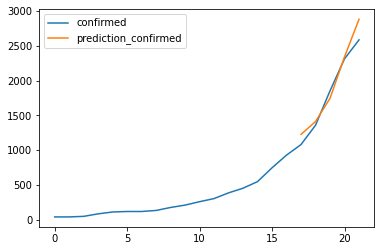

In [6]:
plot_preds(data_pred, 'RU-MOS', 'confirmed')

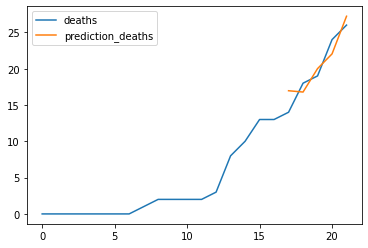

In [7]:
plot_preds(data_pred, 'RU-MOS', 'deaths')

# Обучение модели на всем датасете

In [8]:
model_final = CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=LEARNING_RATE)

runner = SupervisedRunner()
runner.train(
    model=model_final,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X, y), batch_size=BATCH_SIZE, shuffle=False),
        #"valid": DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

Attention, there is only one data loader - train


[2020-04-16 20:26:05,745] 
1/1000 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1000 * Epoch 1 (train): _timer/_fps=132799.9186 | _timer/batch_time=0.0318 | _timer/data_time=0.0313 | _timer/model_time=0.0004 | loss=3.7981
[2020-04-16 20:26:05,816] 
2/1000 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/1000 * Epoch 2 (train): _timer/_fps=170962.0420 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=1.8115
[2020-04-16 20:26:05,887] 
3/1000 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/1000 * Epoch 3 (train): _timer/_fps=173334.5591 | _timer/batch_time=0.0130 | _timer/data_time=0.0126 | _timer/model_time=0.0004 | loss=1.3687
[2020-04-16 20:26:05,949] 
4/1000 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/1000 * Epoch 4 (train): _timer/_fps=190737.2421 | _timer/batch_time=0.0111 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=1.2505
[2020-04-16 20:26:06,017] 
5/1000 * Epoch 5 (_base): lr=0.0010 | momentum=0.9000
5/1000 * Epoch 5 (t

[2020-04-16 20:26:08,435] 
37/1000 * Epoch 37 (_base): lr=0.0010 | momentum=0.9000
37/1000 * Epoch 37 (train): _timer/_fps=180793.9494 | _timer/batch_time=0.0117 | _timer/data_time=0.0113 | _timer/model_time=0.0004 | loss=0.0532
[2020-04-16 20:26:08,519] 
38/1000 * Epoch 38 (_base): lr=0.0010 | momentum=0.9000
38/1000 * Epoch 38 (train): _timer/_fps=144026.7522 | _timer/batch_time=0.0155 | _timer/data_time=0.0150 | _timer/model_time=0.0005 | loss=0.0520
[2020-04-16 20:26:08,592] 
39/1000 * Epoch 39 (_base): lr=0.0010 | momentum=0.9000
39/1000 * Epoch 39 (train): _timer/_fps=162567.1270 | _timer/batch_time=0.0131 | _timer/data_time=0.0126 | _timer/model_time=0.0004 | loss=0.0504
[2020-04-16 20:26:08,657] 
40/1000 * Epoch 40 (_base): lr=0.0010 | momentum=0.9000
40/1000 * Epoch 40 (train): _timer/_fps=182969.9946 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0491
[2020-04-16 20:26:08,730] 
41/1000 * Epoch 41 (_base): lr=0.0010 | momentum=0.9000
4

[2020-04-16 20:26:11,136] 
73/1000 * Epoch 73 (_base): lr=0.0010 | momentum=0.9000
73/1000 * Epoch 73 (train): _timer/_fps=185187.3396 | _timer/batch_time=0.0115 | _timer/data_time=0.0111 | _timer/model_time=0.0004 | loss=0.0301
[2020-04-16 20:26:11,201] 
74/1000 * Epoch 74 (_base): lr=0.0010 | momentum=0.9000
74/1000 * Epoch 74 (train): _timer/_fps=184372.8982 | _timer/batch_time=0.0114 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0289
[2020-04-16 20:26:11,340] 
75/1000 * Epoch 75 (_base): lr=0.0010 | momentum=0.9000
75/1000 * Epoch 75 (train): _timer/_fps=152319.2065 | _timer/batch_time=0.0264 | _timer/data_time=0.0260 | _timer/model_time=0.0004 | loss=0.0283
[2020-04-16 20:26:11,411] 
76/1000 * Epoch 76 (_base): lr=0.0010 | momentum=0.9000
76/1000 * Epoch 76 (train): _timer/_fps=175860.5997 | _timer/batch_time=0.0124 | _timer/data_time=0.0120 | _timer/model_time=0.0004 | loss=0.0294
[2020-04-16 20:26:11,477] 
77/1000 * Epoch 77 (_base): lr=0.0010 | momentum=0.9000
7

[2020-04-16 20:26:13,920] 
109/1000 * Epoch 109 (_base): lr=0.0010 | momentum=0.9000
109/1000 * Epoch 109 (train): _timer/_fps=180473.9987 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0273
[2020-04-16 20:26:13,991] 
110/1000 * Epoch 110 (_base): lr=0.0010 | momentum=0.9000
110/1000 * Epoch 110 (train): _timer/_fps=179942.9129 | _timer/batch_time=0.0120 | _timer/data_time=0.0116 | _timer/model_time=0.0004 | loss=0.0308
[2020-04-16 20:26:14,054] 
111/1000 * Epoch 111 (_base): lr=0.0010 | momentum=0.9000
111/1000 * Epoch 111 (train): _timer/_fps=196475.9622 | _timer/batch_time=0.0108 | _timer/data_time=0.0105 | _timer/model_time=0.0004 | loss=0.0278
[2020-04-16 20:26:14,122] 
112/1000 * Epoch 112 (_base): lr=0.0010 | momentum=0.9000
112/1000 * Epoch 112 (train): _timer/_fps=175567.6887 | _timer/batch_time=0.0119 | _timer/data_time=0.0115 | _timer/model_time=0.0004 | loss=0.0278
[2020-04-16 20:26:14,200] 
113/1000 * Epoch 113 (_base): lr=0.0010 |

[2020-04-16 20:26:16,675] 
145/1000 * Epoch 145 (_base): lr=0.0010 | momentum=0.9000
145/1000 * Epoch 145 (train): _timer/_fps=188169.1049 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0205
[2020-04-16 20:26:16,743] 
146/1000 * Epoch 146 (_base): lr=0.0010 | momentum=0.9000
146/1000 * Epoch 146 (train): _timer/_fps=184491.8015 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0203
[2020-04-16 20:26:16,820] 
147/1000 * Epoch 147 (_base): lr=0.0010 | momentum=0.9000
147/1000 * Epoch 147 (train): _timer/_fps=166646.5031 | _timer/batch_time=0.0137 | _timer/data_time=0.0133 | _timer/model_time=0.0004 | loss=0.0189
[2020-04-16 20:26:16,888] 
148/1000 * Epoch 148 (_base): lr=0.0010 | momentum=0.9000
148/1000 * Epoch 148 (train): _timer/_fps=184003.0901 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0205
[2020-04-16 20:26:16,957] 
149/1000 * Epoch 149 (_base): lr=0.0010 |

[2020-04-16 20:26:19,462] 
181/1000 * Epoch 181 (_base): lr=0.0010 | momentum=0.9000
181/1000 * Epoch 181 (train): _timer/_fps=184668.4109 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0204
[2020-04-16 20:26:19,543] 
182/1000 * Epoch 182 (_base): lr=0.0010 | momentum=0.9000
182/1000 * Epoch 182 (train): _timer/_fps=151420.5286 | _timer/batch_time=0.0141 | _timer/data_time=0.0136 | _timer/model_time=0.0005 | loss=0.0207
[2020-04-16 20:26:19,609] 
183/1000 * Epoch 183 (_base): lr=0.0010 | momentum=0.9000
183/1000 * Epoch 183 (train): _timer/_fps=187045.8054 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0213
[2020-04-16 20:26:19,751] 
184/1000 * Epoch 184 (_base): lr=0.0010 | momentum=0.9000
184/1000 * Epoch 184 (train): _timer/_fps=132991.4487 | _timer/batch_time=0.0263 | _timer/data_time=0.0259 | _timer/model_time=0.0004 | loss=0.0226
[2020-04-16 20:26:19,819] 
185/1000 * Epoch 185 (_base): lr=0.0010 |

[2020-04-16 20:26:22,309] 
217/1000 * Epoch 217 (_base): lr=0.0010 | momentum=0.9000
217/1000 * Epoch 217 (train): _timer/_fps=138836.5035 | _timer/batch_time=0.0258 | _timer/data_time=0.0254 | _timer/model_time=0.0004 | loss=0.0175
[2020-04-16 20:26:22,375] 
218/1000 * Epoch 218 (_base): lr=0.0010 | momentum=0.9000
218/1000 * Epoch 218 (train): _timer/_fps=191472.3820 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0178
[2020-04-16 20:26:22,440] 
219/1000 * Epoch 219 (_base): lr=0.0010 | momentum=0.9000
219/1000 * Epoch 219 (train): _timer/_fps=192841.6595 | _timer/batch_time=0.0110 | _timer/data_time=0.0106 | _timer/model_time=0.0004 | loss=0.0165
[2020-04-16 20:26:22,509] 
220/1000 * Epoch 220 (_base): lr=0.0010 | momentum=0.9000
220/1000 * Epoch 220 (train): _timer/_fps=187732.4330 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0176
[2020-04-16 20:26:22,581] 
221/1000 * Epoch 221 (_base): lr=0.0010 |

[2020-04-16 20:26:25,026] 
253/1000 * Epoch 253 (_base): lr=0.0010 | momentum=0.9000
253/1000 * Epoch 253 (train): _timer/_fps=162084.2884 | _timer/batch_time=0.0141 | _timer/data_time=0.0137 | _timer/model_time=0.0004 | loss=0.0162
[2020-04-16 20:26:25,094] 
254/1000 * Epoch 254 (_base): lr=0.0010 | momentum=0.9000
254/1000 * Epoch 254 (train): _timer/_fps=189308.8853 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0174
[2020-04-16 20:26:25,161] 
255/1000 * Epoch 255 (_base): lr=0.0010 | momentum=0.9000
255/1000 * Epoch 255 (train): _timer/_fps=189875.4723 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0165
[2020-04-16 20:26:25,230] 
256/1000 * Epoch 256 (_base): lr=0.0010 | momentum=0.9000
256/1000 * Epoch 256 (train): _timer/_fps=188671.5871 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0175
[2020-04-16 20:26:25,297] 
257/1000 * Epoch 257 (_base): lr=0.0010 |

[2020-04-16 20:26:27,771] 
289/1000 * Epoch 289 (_base): lr=0.0010 | momentum=0.9000
289/1000 * Epoch 289 (train): _timer/_fps=189727.6827 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0154
[2020-04-16 20:26:27,841] 
290/1000 * Epoch 290 (_base): lr=0.0010 | momentum=0.9000
290/1000 * Epoch 290 (train): _timer/_fps=185344.1571 | _timer/batch_time=0.0115 | _timer/data_time=0.0111 | _timer/model_time=0.0004 | loss=0.0152
[2020-04-16 20:26:27,911] 
291/1000 * Epoch 291 (_base): lr=0.0010 | momentum=0.9000
291/1000 * Epoch 291 (train): _timer/_fps=187102.2321 | _timer/batch_time=0.0114 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0138
[2020-04-16 20:26:27,987] 
292/1000 * Epoch 292 (_base): lr=0.0010 | momentum=0.9000
292/1000 * Epoch 292 (train): _timer/_fps=176326.8747 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0149
[2020-04-16 20:26:28,066] 
293/1000 * Epoch 293 (_base): lr=0.0010 |

[2020-04-16 20:26:30,674] 
325/1000 * Epoch 325 (_base): lr=0.0010 | momentum=0.9000
325/1000 * Epoch 325 (train): _timer/_fps=175994.5482 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0178
[2020-04-16 20:26:30,741] 
326/1000 * Epoch 326 (_base): lr=0.0010 | momentum=0.9000
326/1000 * Epoch 326 (train): _timer/_fps=195455.8026 | _timer/batch_time=0.0109 | _timer/data_time=0.0105 | _timer/model_time=0.0004 | loss=0.0182
[2020-04-16 20:26:30,886] 
327/1000 * Epoch 327 (_base): lr=0.0010 | momentum=0.9000
327/1000 * Epoch 327 (train): _timer/_fps=134005.7802 | _timer/batch_time=0.0266 | _timer/data_time=0.0262 | _timer/model_time=0.0004 | loss=0.0150
[2020-04-16 20:26:30,955] 
328/1000 * Epoch 328 (_base): lr=0.0010 | momentum=0.9000
328/1000 * Epoch 328 (train): _timer/_fps=190100.5551 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0145
[2020-04-16 20:26:31,029] 
329/1000 * Epoch 329 (_base): lr=0.0010 |

[2020-04-16 20:26:33,520] 
361/1000 * Epoch 361 (_base): lr=0.0010 | momentum=0.9000
361/1000 * Epoch 361 (train): _timer/_fps=191820.3443 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0131
[2020-04-16 20:26:33,593] 
362/1000 * Epoch 362 (_base): lr=0.0010 | momentum=0.9000
362/1000 * Epoch 362 (train): _timer/_fps=187213.9778 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0129
[2020-04-16 20:26:33,669] 
363/1000 * Epoch 363 (_base): lr=0.0010 | momentum=0.9000
363/1000 * Epoch 363 (train): _timer/_fps=166036.8568 | _timer/batch_time=0.0124 | _timer/data_time=0.0120 | _timer/model_time=0.0004 | loss=0.0132
[2020-04-16 20:26:33,740] 
364/1000 * Epoch 364 (_base): lr=0.0010 | momentum=0.9000
364/1000 * Epoch 364 (train): _timer/_fps=187809.4196 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0139
[2020-04-16 20:26:33,811] 
365/1000 * Epoch 365 (_base): lr=0.0010 |

[2020-04-16 20:26:36,328] 
397/1000 * Epoch 397 (_base): lr=0.0010 | momentum=0.9000
397/1000 * Epoch 397 (train): _timer/_fps=191494.4371 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0139
[2020-04-16 20:26:36,401] 
398/1000 * Epoch 398 (_base): lr=0.0010 | momentum=0.9000
398/1000 * Epoch 398 (train): _timer/_fps=181933.2483 | _timer/batch_time=0.0117 | _timer/data_time=0.0113 | _timer/model_time=0.0004 | loss=0.0132
[2020-04-16 20:26:36,479] 
399/1000 * Epoch 399 (_base): lr=0.0010 | momentum=0.9000
399/1000 * Epoch 399 (train): _timer/_fps=180441.2919 | _timer/batch_time=0.0119 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0129
[2020-04-16 20:26:36,555] 
400/1000 * Epoch 400 (_base): lr=0.0010 | momentum=0.9000
400/1000 * Epoch 400 (train): _timer/_fps=175920.7966 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0005 | loss=0.0125
[2020-04-16 20:26:36,632] 
401/1000 * Epoch 401 (_base): lr=0.0010 |

[2020-04-16 20:26:39,297] 
433/1000 * Epoch 433 (_base): lr=0.0010 | momentum=0.9000
433/1000 * Epoch 433 (train): _timer/_fps=190195.9207 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0146
[2020-04-16 20:26:39,371] 
434/1000 * Epoch 434 (_base): lr=0.0010 | momentum=0.9000
434/1000 * Epoch 434 (train): _timer/_fps=181997.3843 | _timer/batch_time=0.0117 | _timer/data_time=0.0113 | _timer/model_time=0.0004 | loss=0.0156
[2020-04-16 20:26:39,443] 
435/1000 * Epoch 435 (_base): lr=0.0010 | momentum=0.9000
435/1000 * Epoch 435 (train): _timer/_fps=191433.5148 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0181
[2020-04-16 20:26:39,512] 
436/1000 * Epoch 436 (_base): lr=0.0010 | momentum=0.9000
436/1000 * Epoch 436 (train): _timer/_fps=191368.5213 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0159
[2020-04-16 20:26:39,664] 
437/1000 * Epoch 437 (_base): lr=0.0010 |

[2020-04-16 20:26:42,246] 
469/1000 * Epoch 469 (_base): lr=0.0010 | momentum=0.9000
469/1000 * Epoch 469 (train): _timer/_fps=187323.9805 | _timer/batch_time=0.0114 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0137
[2020-04-16 20:26:42,390] 
470/1000 * Epoch 470 (_base): lr=0.0010 | momentum=0.9000
470/1000 * Epoch 470 (train): _timer/_fps=141640.2863 | _timer/batch_time=0.0258 | _timer/data_time=0.0254 | _timer/model_time=0.0004 | loss=0.0141
[2020-04-16 20:26:42,462] 
471/1000 * Epoch 471 (_base): lr=0.0010 | momentum=0.9000
471/1000 * Epoch 471 (train): _timer/_fps=187844.8669 | _timer/batch_time=0.0113 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0140
[2020-04-16 20:26:42,532] 
472/1000 * Epoch 472 (_base): lr=0.0010 | momentum=0.9000
472/1000 * Epoch 472 (train): _timer/_fps=192071.6531 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0138
[2020-04-16 20:26:42,605] 
473/1000 * Epoch 473 (_base): lr=0.0010 |

[2020-04-16 20:26:45,302] 
505/1000 * Epoch 505 (_base): lr=0.0010 | momentum=0.9000
505/1000 * Epoch 505 (train): _timer/_fps=166249.9827 | _timer/batch_time=0.0128 | _timer/data_time=0.0124 | _timer/model_time=0.0004 | loss=0.0126
[2020-04-16 20:26:45,383] 
506/1000 * Epoch 506 (_base): lr=0.0010 | momentum=0.9000
506/1000 * Epoch 506 (train): _timer/_fps=178266.0819 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0131
[2020-04-16 20:26:45,457] 
507/1000 * Epoch 507 (_base): lr=0.0010 | momentum=0.9000
507/1000 * Epoch 507 (train): _timer/_fps=193411.7932 | _timer/batch_time=0.0110 | _timer/data_time=0.0106 | _timer/model_time=0.0004 | loss=0.0127
[2020-04-16 20:26:45,532] 
508/1000 * Epoch 508 (_base): lr=0.0010 | momentum=0.9000
508/1000 * Epoch 508 (train): _timer/_fps=191114.8455 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0124
[2020-04-16 20:26:45,606] 
509/1000 * Epoch 509 (_base): lr=0.0010 |

[2020-04-16 20:26:48,352] 
541/1000 * Epoch 541 (_base): lr=0.0010 | momentum=0.9000
541/1000 * Epoch 541 (train): _timer/_fps=163641.0915 | _timer/batch_time=0.0130 | _timer/data_time=0.0126 | _timer/model_time=0.0004 | loss=0.0125
[2020-04-16 20:26:48,440] 
542/1000 * Epoch 542 (_base): lr=0.0010 | momentum=0.9000
542/1000 * Epoch 542 (train): _timer/_fps=160961.4552 | _timer/batch_time=0.0132 | _timer/data_time=0.0128 | _timer/model_time=0.0004 | loss=0.0143
[2020-04-16 20:26:48,528] 
543/1000 * Epoch 543 (_base): lr=0.0010 | momentum=0.9000
543/1000 * Epoch 543 (train): _timer/_fps=161086.1607 | _timer/batch_time=0.0132 | _timer/data_time=0.0128 | _timer/model_time=0.0004 | loss=0.0149
[2020-04-16 20:26:48,616] 
544/1000 * Epoch 544 (_base): lr=0.0010 | momentum=0.9000
544/1000 * Epoch 544 (train): _timer/_fps=160911.4930 | _timer/batch_time=0.0132 | _timer/data_time=0.0128 | _timer/model_time=0.0004 | loss=0.0156
[2020-04-16 20:26:48,703] 
545/1000 * Epoch 545 (_base): lr=0.0010 |

[2020-04-16 20:26:51,368] 
577/1000 * Epoch 577 (_base): lr=0.0010 | momentum=0.9000
577/1000 * Epoch 577 (train): _timer/_fps=180699.7964 | _timer/batch_time=0.0122 | _timer/data_time=0.0118 | _timer/model_time=0.0004 | loss=0.0093
[2020-04-16 20:26:51,443] 
578/1000 * Epoch 578 (_base): lr=0.0010 | momentum=0.9000
578/1000 * Epoch 578 (train): _timer/_fps=190865.7149 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0093
[2020-04-16 20:26:51,519] 
579/1000 * Epoch 579 (_base): lr=0.0010 | momentum=0.9000
579/1000 * Epoch 579 (train): _timer/_fps=188782.7655 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0092
[2020-04-16 20:26:51,664] 
580/1000 * Epoch 580 (_base): lr=0.0010 | momentum=0.9000
580/1000 * Epoch 580 (train): _timer/_fps=141434.9641 | _timer/batch_time=0.0258 | _timer/data_time=0.0254 | _timer/model_time=0.0004 | loss=0.0094
[2020-04-16 20:26:51,740] 
581/1000 * Epoch 581 (_base): lr=0.0010 |

[2020-04-16 20:26:54,503] 
613/1000 * Epoch 613 (_base): lr=0.0010 | momentum=0.9000
613/1000 * Epoch 613 (train): _timer/_fps=141745.9670 | _timer/batch_time=0.0258 | _timer/data_time=0.0254 | _timer/model_time=0.0004 | loss=0.0170
[2020-04-16 20:26:54,580] 
614/1000 * Epoch 614 (_base): lr=0.0010 | momentum=0.9000
614/1000 * Epoch 614 (train): _timer/_fps=181447.7324 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0151
[2020-04-16 20:26:54,668] 
615/1000 * Epoch 615 (_base): lr=0.0010 | momentum=0.9000
615/1000 * Epoch 615 (train): _timer/_fps=161680.4366 | _timer/batch_time=0.0132 | _timer/data_time=0.0127 | _timer/model_time=0.0004 | loss=0.0155
[2020-04-16 20:26:54,755] 
616/1000 * Epoch 616 (_base): lr=0.0010 | momentum=0.9000
616/1000 * Epoch 616 (train): _timer/_fps=162640.4388 | _timer/batch_time=0.0131 | _timer/data_time=0.0127 | _timer/model_time=0.0004 | loss=0.0121
[2020-04-16 20:26:54,841] 
617/1000 * Epoch 617 (_base): lr=0.0010 |

[2020-04-16 20:26:57,563] 
649/1000 * Epoch 649 (_base): lr=0.0010 | momentum=0.9000
649/1000 * Epoch 649 (train): _timer/_fps=192555.9634 | _timer/batch_time=0.0110 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0099
[2020-04-16 20:26:57,647] 
650/1000 * Epoch 650 (_base): lr=0.0010 | momentum=0.9000
650/1000 * Epoch 650 (train): _timer/_fps=170734.0835 | _timer/batch_time=0.0132 | _timer/data_time=0.0127 | _timer/model_time=0.0005 | loss=0.0101
[2020-04-16 20:26:57,728] 
651/1000 * Epoch 651 (_base): lr=0.0010 | momentum=0.9000
651/1000 * Epoch 651 (train): _timer/_fps=176734.7918 | _timer/batch_time=0.0124 | _timer/data_time=0.0120 | _timer/model_time=0.0004 | loss=0.0098
[2020-04-16 20:26:57,808] 
652/1000 * Epoch 652 (_base): lr=0.0010 | momentum=0.9000
652/1000 * Epoch 652 (train): _timer/_fps=191619.5181 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0096
[2020-04-16 20:26:57,889] 
653/1000 * Epoch 653 (_base): lr=0.0010 |

[2020-04-16 20:27:00,655] 
685/1000 * Epoch 685 (_base): lr=0.0010 | momentum=0.9000
685/1000 * Epoch 685 (train): _timer/_fps=188714.9582 | _timer/batch_time=0.0113 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0207
[2020-04-16 20:27:00,729] 
686/1000 * Epoch 686 (_base): lr=0.0010 | momentum=0.9000
686/1000 * Epoch 686 (train): _timer/_fps=189844.2600 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0137
[2020-04-16 20:27:00,816] 
687/1000 * Epoch 687 (_base): lr=0.0010 | momentum=0.9000
687/1000 * Epoch 687 (train): _timer/_fps=177505.6945 | _timer/batch_time=0.0126 | _timer/data_time=0.0122 | _timer/model_time=0.0004 | loss=0.0152
[2020-04-16 20:27:00,899] 
688/1000 * Epoch 688 (_base): lr=0.0010 | momentum=0.9000
688/1000 * Epoch 688 (train): _timer/_fps=188801.9215 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0130
[2020-04-16 20:27:00,976] 
689/1000 * Epoch 689 (_base): lr=0.0010 |

[2020-04-16 20:27:03,818] 
721/1000 * Epoch 721 (_base): lr=0.0010 | momentum=0.9000
721/1000 * Epoch 721 (train): _timer/_fps=181576.7740 | _timer/batch_time=0.0118 | _timer/data_time=0.0114 | _timer/model_time=0.0004 | loss=0.0090
[2020-04-16 20:27:03,904] 
722/1000 * Epoch 722 (_base): lr=0.0010 | momentum=0.9000
722/1000 * Epoch 722 (train): _timer/_fps=174502.4247 | _timer/batch_time=0.0122 | _timer/data_time=0.0117 | _timer/model_time=0.0005 | loss=0.0092
[2020-04-16 20:27:04,062] 
723/1000 * Epoch 723 (_base): lr=0.0010 | momentum=0.9000
723/1000 * Epoch 723 (train): _timer/_fps=135863.3931 | _timer/batch_time=0.0271 | _timer/data_time=0.0267 | _timer/model_time=0.0004 | loss=0.0089
[2020-04-16 20:27:04,147] 
724/1000 * Epoch 724 (_base): lr=0.0010 | momentum=0.9000
724/1000 * Epoch 724 (train): _timer/_fps=170759.1865 | _timer/batch_time=0.0130 | _timer/data_time=0.0124 | _timer/model_time=0.0005 | loss=0.0086
[2020-04-16 20:27:04,227] 
725/1000 * Epoch 725 (_base): lr=0.0010 |

[2020-04-16 20:27:06,961] 
757/1000 * Epoch 757 (_base): lr=0.0010 | momentum=0.9000
757/1000 * Epoch 757 (train): _timer/_fps=192530.1384 | _timer/batch_time=0.0110 | _timer/data_time=0.0106 | _timer/model_time=0.0004 | loss=0.0128
[2020-04-16 20:27:07,040] 
758/1000 * Epoch 758 (_base): lr=0.0010 | momentum=0.9000
758/1000 * Epoch 758 (train): _timer/_fps=189714.9813 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0140
[2020-04-16 20:27:07,120] 
759/1000 * Epoch 759 (_base): lr=0.0010 | momentum=0.9000
759/1000 * Epoch 759 (train): _timer/_fps=182420.6413 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0142
[2020-04-16 20:27:07,204] 
760/1000 * Epoch 760 (_base): lr=0.0010 | momentum=0.9000
760/1000 * Epoch 760 (train): _timer/_fps=182379.9823 | _timer/batch_time=0.0116 | _timer/data_time=0.0112 | _timer/model_time=0.0004 | loss=0.0117
[2020-04-16 20:27:07,293] 
761/1000 * Epoch 761 (_base): lr=0.0010 |

[2020-04-16 20:27:10,328] 
793/1000 * Epoch 793 (_base): lr=0.0010 | momentum=0.9000
793/1000 * Epoch 793 (train): _timer/_fps=160707.1860 | _timer/batch_time=0.0132 | _timer/data_time=0.0128 | _timer/model_time=0.0004 | loss=0.0102
[2020-04-16 20:27:10,411] 
794/1000 * Epoch 794 (_base): lr=0.0010 | momentum=0.9000
794/1000 * Epoch 794 (train): _timer/_fps=189721.4543 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0116
[2020-04-16 20:27:10,489] 
795/1000 * Epoch 795 (_base): lr=0.0010 | momentum=0.9000
795/1000 * Epoch 795 (train): _timer/_fps=184754.5618 | _timer/batch_time=0.0115 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0106
[2020-04-16 20:27:10,568] 
796/1000 * Epoch 796 (_base): lr=0.0010 | momentum=0.9000
796/1000 * Epoch 796 (train): _timer/_fps=188656.3246 | _timer/batch_time=0.0113 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0113
[2020-04-16 20:27:10,651] 
797/1000 * Epoch 797 (_base): lr=0.0010 |

[2020-04-16 20:27:13,734] 
829/1000 * Epoch 829 (_base): lr=0.0010 | momentum=0.9000
829/1000 * Epoch 829 (train): _timer/_fps=143418.9673 | _timer/batch_time=0.0282 | _timer/data_time=0.0277 | _timer/model_time=0.0005 | loss=0.0121
[2020-04-16 20:27:13,821] 
830/1000 * Epoch 830 (_base): lr=0.0010 | momentum=0.9000
830/1000 * Epoch 830 (train): _timer/_fps=186236.0005 | _timer/batch_time=0.0114 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0112
[2020-04-16 20:27:13,907] 
831/1000 * Epoch 831 (_base): lr=0.0010 | momentum=0.9000
831/1000 * Epoch 831 (train): _timer/_fps=168507.2995 | _timer/batch_time=0.0122 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0119
[2020-04-16 20:27:13,985] 
832/1000 * Epoch 832 (_base): lr=0.0010 | momentum=0.9000
832/1000 * Epoch 832 (train): _timer/_fps=187757.9802 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0111
[2020-04-16 20:27:14,068] 
833/1000 * Epoch 833 (_base): lr=0.0010 |

[2020-04-16 20:27:17,052] 
865/1000 * Epoch 865 (_base): lr=0.0010 | momentum=0.9000
865/1000 * Epoch 865 (train): _timer/_fps=189653.9977 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0089
[2020-04-16 20:27:17,132] 
866/1000 * Epoch 866 (_base): lr=0.0010 | momentum=0.9000
866/1000 * Epoch 866 (train): _timer/_fps=191315.2639 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0089
[2020-04-16 20:27:17,213] 
867/1000 * Epoch 867 (_base): lr=0.0010 | momentum=0.9000
867/1000 * Epoch 867 (train): _timer/_fps=191870.7383 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0090
[2020-04-16 20:27:17,301] 
868/1000 * Epoch 868 (_base): lr=0.0010 | momentum=0.9000
868/1000 * Epoch 868 (train): _timer/_fps=185467.0508 | _timer/batch_time=0.0121 | _timer/data_time=0.0117 | _timer/model_time=0.0004 | loss=0.0088
[2020-04-16 20:27:17,377] 
869/1000 * Epoch 869 (_base): lr=0.0010 |

[2020-04-16 20:27:20,230] 
901/1000 * Epoch 901 (_base): lr=0.0010 | momentum=0.9000
901/1000 * Epoch 901 (train): _timer/_fps=189933.7251 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0107
[2020-04-16 20:27:20,308] 
902/1000 * Epoch 902 (_base): lr=0.0010 | momentum=0.9000
902/1000 * Epoch 902 (train): _timer/_fps=190009.8927 | _timer/batch_time=0.0111 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0108
[2020-04-16 20:27:20,389] 
903/1000 * Epoch 903 (_base): lr=0.0010 | momentum=0.9000
903/1000 * Epoch 903 (train): _timer/_fps=189782.1515 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0100
[2020-04-16 20:27:20,468] 
904/1000 * Epoch 904 (_base): lr=0.0010 | momentum=0.9000
904/1000 * Epoch 904 (train): _timer/_fps=188967.0236 | _timer/batch_time=0.0112 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0093
[2020-04-16 20:27:20,628] 
905/1000 * Epoch 905 (_base): lr=0.0010 |

[2020-04-16 20:27:23,511] 
937/1000 * Epoch 937 (_base): lr=0.0010 | momentum=0.9000
937/1000 * Epoch 937 (train): _timer/_fps=182375.9273 | _timer/batch_time=0.0117 | _timer/data_time=0.0113 | _timer/model_time=0.0004 | loss=0.0106
[2020-04-16 20:27:23,672] 
938/1000 * Epoch 938 (_base): lr=0.0010 | momentum=0.9000
938/1000 * Epoch 938 (train): _timer/_fps=161305.6545 | _timer/batch_time=0.0259 | _timer/data_time=0.0255 | _timer/model_time=0.0004 | loss=0.0100
[2020-04-16 20:27:23,754] 
939/1000 * Epoch 939 (_base): lr=0.0010 | momentum=0.9000
939/1000 * Epoch 939 (train): _timer/_fps=190713.5888 | _timer/batch_time=0.0111 | _timer/data_time=0.0108 | _timer/model_time=0.0004 | loss=0.0095
[2020-04-16 20:27:23,833] 
940/1000 * Epoch 940 (_base): lr=0.0010 | momentum=0.9000
940/1000 * Epoch 940 (train): _timer/_fps=191301.0924 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=0.0098
[2020-04-16 20:27:23,916] 
941/1000 * Epoch 941 (_base): lr=0.0010 |

[2020-04-16 20:27:26,883] 
973/1000 * Epoch 973 (_base): lr=0.0010 | momentum=0.9000
973/1000 * Epoch 973 (train): _timer/_fps=188526.3410 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0084
[2020-04-16 20:27:26,967] 
974/1000 * Epoch 974 (_base): lr=0.0010 | momentum=0.9000
974/1000 * Epoch 974 (train): _timer/_fps=188939.0387 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0083
[2020-04-16 20:27:27,050] 
975/1000 * Epoch 975 (_base): lr=0.0010 | momentum=0.9000
975/1000 * Epoch 975 (train): _timer/_fps=188323.6167 | _timer/batch_time=0.0113 | _timer/data_time=0.0109 | _timer/model_time=0.0004 | loss=0.0084
[2020-04-16 20:27:27,136] 
976/1000 * Epoch 976 (_base): lr=0.0010 | momentum=0.9000
976/1000 * Epoch 976 (train): _timer/_fps=187964.3564 | _timer/batch_time=0.0113 | _timer/data_time=0.0110 | _timer/model_time=0.0004 | loss=0.0087
[2020-04-16 20:27:27,219] 
977/1000 * Epoch 977 (_base): lr=0.0010 |

# Предсказание

In [14]:
PREDICT_DAYS = 8


def predict_next_day(current_data):
    last_date = current_data['date'].max()
    next_date = last_date + pd.to_timedelta(1, unit='d')

    prev_data = current_data[current_data['date'] == last_date]
    values = []
    for country in prev_data['country']:
        values.append([next_date, country, 0, 0])

    next_data = pd.DataFrame(values, columns=current_data.columns)
    combined_data = current_data.append(next_data)
    next_X = get_X(combined_data)[combined_data['date'] == next_date]

    next_data[['confirmed', 'deaths']] = runner.predict_loader(
        model_final,
        DataLoader(CovidDataset(next_X), batch_size=BATCH_SIZE, shuffle=False),
    )

    return next_data


def predict(data, num_days=PREDICT_DAYS):
    predict_data = pd.DataFrame(columns=data.columns)

    for i in range(PREDICT_DAYS):
        all_data = data.append(predict_data)
        next_day_data = predict_next_day(all_data)
        predict_data = predict_data.append(next_day_data)

    return predict_data.rename(columns={
        'confirmed': 'prediction_confirmed',
        'deaths': 'prediction_deaths',
    })

predicts = predict(data)
predicts

     is_region      lat      long  confirmed_prev1  deaths_prev1  \
0            0  33.0000   65.0000         2.894870      1.414973   
1            0 -11.2027   17.8739         1.301030      0.477121   
2            0  41.1533   20.1683         2.694605      1.414973   
3            0  42.5063    1.5218         2.828660      1.531479   
4            0  24.0000   54.0000         3.729651      1.531479   
..         ...      ...       ...              ...           ...   
248          0   6.4238  -66.5897         2.296665      1.000000   
249          0  16.0000  108.0000         2.428135      0.000000   
250          0 -30.5595   22.9375         3.399154      1.544068   
251          0 -15.4167   28.2833         1.690196      0.477121   
252          0 -20.0000   30.0000         1.380211      0.602060   

     confirmed_prev2  deaths_prev2  confirmed_prev3  deaths_prev3  \
0           2.854306      1.380211         2.823474      1.342423   
1           1.301030      0.477121         1.

     is_region      lat      long  confirmed_prev1  deaths_prev1  \
0            0  33.0000   65.0000         2.436223      0.949880   
1            0 -11.2027   17.8739         1.106175      0.348945   
2            0  41.1533   20.1683         2.318807      0.963898   
3            0  42.5063    1.5218         2.568495      1.239900   
4            0  24.0000   54.0000         3.047340      1.200799   
..         ...      ...       ...              ...           ...   
248          0   6.4238  -66.5897         2.867228      1.216551   
249          0  16.0000  108.0000         1.618417     -0.230644   
250          0 -30.5595   22.9375         3.354539      1.539278   
251          0 -15.4167   28.2833         1.397229      0.289336   
252          0 -20.0000   30.0000         1.131760      0.334402   

     confirmed_prev2  deaths_prev2  confirmed_prev3  deaths_prev3  \
0           2.508948      1.036250         2.589184      1.117894   
1           1.137821      0.371166         1.

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-16,AFG,2.783707,1.323124
1,2020-04-16,AGO,1.258773,0.452515
2,2020-04-16,ALB,2.615279,1.318367
3,2020-04-16,AND,2.776292,1.470991
4,2020-04-16,ARE,3.564013,1.456760
...,...,...,...,...
248,2020-04-23,VEN,3.048603,1.303289
249,2020-04-23,VNM,1.337048,-0.320289
250,2020-04-23,ZAF,3.333142,1.520328
251,2020-04-23,ZMB,1.333955,0.247826


# Визуализация

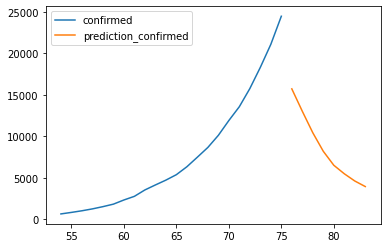

In [13]:
data_pred = data.append(predicts)
plot_preds(data_pred, 'RUS', 'confirmed')

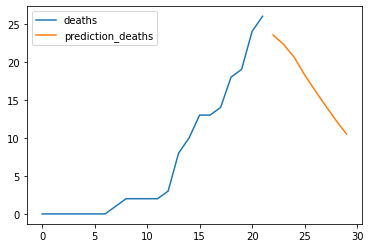

In [11]:
plot_preds(data_pred, 'RU-MOS', 'deaths')

# Сохранение

In [12]:
PREDICT_COLUMNS = ['prediction_confirmed', 'prediction_deaths']

df = predicts.copy()
df[PREDICT_COLUMNS] = (10 ** df[PREDICT_COLUMNS] - 1).astype(int)

df.to_csv('data/submission.csv', index=False)